## Load data


In [4]:
% load_ext autoreload
% autoreload 2

In [5]:
import os

# do we have the correct env loaded?
assert 'donkey2' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

In [6]:
import numpy as np

fast_model_IND_test_activations = np.load("nighttime_ai_fast_model_fast_data_activations.npy")
fast_model_OOD_activations = np.load("nighttime_ai_fast_model_slow_data_activations.npy")
slow_model_OOD_activations = np.load("nighttime_ai_slow_model_fast_data_activations.npy")
slow_model_IND_test_activations = np.load("nighttime_ai_slow_model_slow_data_activations.npy")

[d.shape for d in (fast_model_IND_test_activations, fast_model_OOD_activations, slow_model_OOD_activations,
                   slow_model_IND_test_activations)]

[(19250, 256), (20304, 256), (19250, 256), (20304, 256)]

In [7]:

fast_model_IND_train = fast_model_IND_test_activations[:9500, :]
fast_model_IND_test = fast_model_IND_test_activations[9500:9500 + 9500, :]
fast_model_IND_train.shape, fast_model_IND_test.shape

((9500, 256), (9500, 256))

In [8]:
slow_model_IND_train = slow_model_IND_test_activations[:9500]
slow_model_IND_test = slow_model_IND_test_activations[9500:9500 + 9500]
slow_model_IND_train.shape, slow_model_IND_test.shape

((9500, 256), (9500, 256))

## Mahalanobis

In [9]:
import numpy as np


def cal_mahal_dist(x, y, for_cov):
    matrix_center = np.mean(y, axis=0)
    delta = x - matrix_center

    # calculate the covariance matrix and its inverse matrix
    cov_matrix = np.cov(for_cov, rowvar=False, ddof=1)
    cov_matrix_inv = np.linalg.pinv(cov_matrix)

    # calculate the Mahalanobis distance between a single vector and the center of the dataset
    def md_vector(vector):
        inner_prod = np.dot(vector, cov_matrix_inv)
        dist = np.sqrt(np.dot(inner_prod, vector))
        return dist

    mahal_dist = np.apply_along_axis(arr=delta, axis=1, func1d=md_vector)
    assert len(mahal_dist) == len(x)
    return mahal_dist


def mahalanobis(x, cluster_center, for_cov):
    """
    @param x: 2D array of the shape (nxm) n: samples, m: dimensions
    @param cluster_center: 1 D array with length m: dimensions
    @param for_cov: 2D array of the shape (nxm) n: samples, m: dimensions - used for covariance matrix
    @return: a 1D array of the length n which contains mahalanobis distance for each sample in x
    """
    assert len(x.shape) == 2
    assert len(cluster_center.shape) == 1
    assert x.shape[1] == cluster_center.shape[0]

    d = np.repeat(cluster_center.reshape(1, -1), len(x), axis=0)

    return cal_mahal_dist(x, d, for_cov)


In [14]:
from sklearn.cluster import KMeans


def get_mahal_scores_from_kmeans_clusters(train, val, test):
    N = 3
    model = KMeans(n_clusters=N, random_state=0)
    model.fit(train)
    mahal_train = []
    mahal_test = []
    mahal_ood = []

    for cluster_center in model.cluster_centers_:
        mahal_train.append(mahalanobis(train, cluster_center, train))
        mahal_test.append(mahalanobis(val, cluster_center, train))
        mahal_ood.append(mahalanobis(test, cluster_center, train))

    mahal_train = np.min(np.array(mahal_train), axis=0).T
    mahal_test = np.min(np.array(mahal_test), axis=0).T
    mahal_ood = np.min(np.array(mahal_ood), axis=0).T

    print(mahal_train.mean(), mahal_test.mean(), mahal_ood.mean())

    return mahal_train, mahal_test, mahal_ood


mahal_train_fast, mahal_test_fast, mahal_ood_fast = get_mahal_scores_from_kmeans_clusters(fast_model_IND_train, fast_model_IND_test, fast_model_OOD_activations)

mahal_train_slow, mahal_test_slow, mahal_ood_slow = get_mahal_scores_from_kmeans_clusters(slow_model_IND_train, slow_model_IND_test, slow_model_OOD_activations)


15.639499521692583 16.185765321302288 100.44562083780401
15.670068321234627 16.552869273682777 65.9027447862157


## AUROC

In [15]:
fast_IND_mahal = np.vstack([mahal_test_fast, np.zeros(len(mahal_test_fast))]).T
fast_OOD_mahal = np.vstack([mahal_ood_fast, np.ones(len(mahal_ood_fast))]).T
slow_IND_mahal = np.vstack([mahal_test_slow, np.zeros(len(mahal_test_slow))]).T
slow_OOD_mahal = np.vstack([mahal_ood_slow, np.ones(len(mahal_ood_slow))]).T


In [16]:
data = np.concatenate((fast_IND_mahal,
                       fast_OOD_mahal,
                       slow_IND_mahal,
                       slow_OOD_mahal))
data.shape

(58554, 2)

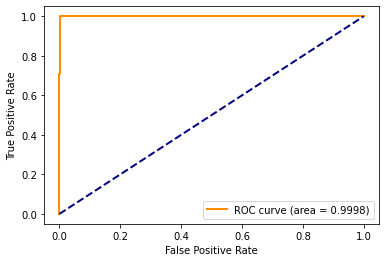

In [17]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

lw = 2
fpr, tpr, _ = roc_curve(data[:, 1], data[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


